<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2 - Ames Housing Data and Kaggle Challenge

_Authors: Patrick Wales-Dinan_

---

This lab was incredibly challenging. We had to extensively clean a date set that was missing a lot of values and had TONS of categorical data. Then we had to decide what features to use to model that data. After that we had to build and fit the models making decisions like whether to use polynomial features, dummy variables etc, log scaling features or log scaling the depended variable.

After that we had to re run our model over and over again, looking at the different values of $\beta$ and seeing if they were contributing to the predictive power of the model. We had to decide if we should throw those values out or if we should leave them. We also had to make judgement calls to see if our model appeared to be over fitting or suffering from bias. 

## Contents:
- [Data Import](#Data-Import)
- [Feature Creation](#Feature-Creation)
- [Choosing the Features](#Feature-Choice)
- [Log Scaling](#Log-Scaling-Independent-Variables)
- [Cleaning the Data and Modifying the Data](#Cleaning-&-Creating-the-Data-Set)
- [Modeling the Data](#Modeling-the-Data)
- [Model Analysis](#Analyzing-the-model)

Please visit the Graphs & Relationships notebook for additional visuals: http://localhost:8891/notebooks/Project_2_Graphs%20%26%20Relationships.ipynb


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import Imputer
import math

import copy
import argparse

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


%matplotlib inline

## Data Import

In [2]:
# Reading in the dataset
ames_train = pd.read_csv('./datasets/train.csv')
ames_test = pd.read_csv('./datasets/test.csv')
ames_test_1 = pd.read_csv('./datasets/test.csv')
ames_train_cate = ames_train.select_dtypes(include='object')
ames_test_cate = ames_train.select_dtypes(include='object')
test_id = ames_test['Id'].to_frame()
Sale = (ames_train['SalePrice'])
print(ames_train.shape)
print(ames_test.shape)
print(Sale.mean())

(2051, 81)
(879, 80)
181469.70160897123


In [ ]:
# This function calculate the mean value relative to sale price of every categorical variable and replaces the 
# Corresponding levels with them ***NOTE*** it takes a long time to run as it has to iterate through every value of
# Every level of every variable. Typically over an hour for each of the training and test dataset.
Sale = (ames_train['SalePrice'])

def mean_level(df, col, index):
    mean = df.loc[df[col] == index]['SalePrice'].mean()
    return mean

def replace_with_sq_mean(df, col_list, inplace=True):
    df2 = df.copy()
    for col in col_list:
        for (index, val) in df[col].iteritems():
            mean = mean_level(df, col, val)
            df2[col][index] = mean
    return df2


In [ ]:
ames_train = replace_with_sq_mean(ames_train, ames_train_cate.columns)

In [ ]:
ames_test['SalePrice'] = Sale
ames_test = replace_with_sq_mean(ames_test, ames_test_cate.columns)

## Feature Creation

In [3]:
# Feature Creation this cell contains many different features that I created to test.
ames_train['home_age'] = ames_train['Yr Sold'] - ames_train['Year Built']
ames_test['home_age'] = ames_test['Yr Sold'] - ames_test['Year Built']
ames_train['base_1st'] = ames_train['Total Bsmt SF'] * ames_train['1st Flr SF']
ames_test['base_1st'] = ames_test['Total Bsmt SF'] * ames_test['1st Flr SF']
ames_train['quality_age'] = ames_train['Overall Qual'] * ames_train['home_age']
ames_test['quality_age'] = ames_test['Overall Qual'] * ames_test['home_age']
ames_train['quality_sq_ft'] = ames_train['Overall Qual'] * ames_train['1st Flr SF']
ames_test['quality_sq_ft'] = ames_test['Overall Qual'] * ames_test['1st Flr SF']
ames_train['garage_area_cars'] = ames_train['Garage Area'] * ames_train['Garage Cars']
ames_test['garage_area_cars'] = ames_test['Garage Area'] * ames_test['Garage Cars']
ames_train['qual_neig'] = ames_train['Neighborhood'] * ames_train['Overall Qual']
ames_test['qual_neig'] = ames_test['Neighborhood'] * ames_test['Overall Qual']
ames_train['Quality_sq'] = ames_train['Overall Qual'] * ames_train['Overall Qual']
ames_test['Quality_sq'] = ames_test['Overall Qual'] * ames_test['Overall Qual']
ames_train['GLA_OQ'] = ames_train['Gr Liv Area'] * ames_train['Overall Qual']
ames_test['GLA_OQ'] = ames_test['Gr Liv Area'] * ames_test['Overall Qual']
ames_train['GLA_SQ'] = ames_train['Gr Liv Area'] * ames_train['Gr Liv Area']
ames_test['GLA_SQ'] = ames_test['Gr Liv Area'] * ames_test['Gr Liv Area']
ames_train['Yr_brm'] = ames_train['Year Built'] * ames_train['Year Remod/Add']
ames_test['Yr_brm'] = ames_test['Year Built'] * ames_test['Year Remod/Add']
ames_train['GLA_Bath'] = ames_train['Gr Liv Area'] * ames_train['Full Bath']
ames_test['GLA_Bath'] = ames_test['Gr Liv Area'] * ames_test['Full Bath']
ames_train['GLA_Garage'] = ames_train['Gr Liv Area'] * ames_train['garage_area_cars']
ames_test['GLA_Garage'] = ames_test['Gr Liv Area'] * ames_test['garage_area_cars']
ames_train['garage'] = ames_train['Garage Area'] > 0
ames_test['garage'] = ames_test['Garage Area'] > 0
ames_train['Qual_Gar'] = ames_train['Overall Qual'] * ames_train['garage']
ames_test['Qual_Gar'] = ames_test['Overall Qual'] * ames_test['garage']
ames_train['Qual_Liv_Gar'] = ames_train['Overall Qual'] * ames_train['Gr Liv Area'] * ames_train['Garage Area']
ames_test['Qual_Liv_Gar'] = ames_test['Overall Qual'] * ames_test['Gr Liv Area'] * ames_test['Garage Area']
ames_train['Qual*GLA*Lot'] = ames_train['Overall Qual'] * ames_train['Gr Liv Area'] * ames_train['Lot Area']
ames_test['Qual*GLA*Lot'] = ames_test['Overall Qual'] * ames_test['Gr Liv Area'] * ames_test['Lot Area']
# ames_test['Quality_rhood'] = ames_test['Overall Qual'] * ames_test['rich_hood']
# ames_train['Quality_rhood'] = ames_train['Overall Qual'] * ames_train['rich_hood']
# ames_test['Quality_phood'] = ames_test['Overall Qual'] * ames_test['poor_hood']
# ames_train['Quality_phood'] = ames_train['Overall Qual'] * ames_train['poor_hood']
# ames_test['Area_rhood'] = ames_test['Gr Liv Area'] * ames_test['rich_hood']
# ames_train['Area_rhood'] = ames_train['Gr Liv Area'] * ames_train['rich_hood']
# ames_test['EXTQUAL_GLA'] = ames_test['EX_Q'] * ames_test['Gr Liv Area']
# ames_train['EXTQUAL_GLA'] = ames_train['EX_Q'] * ames_train['Gr Liv Area']
# ames_test['Q_rhood'] = ames_test['Overall Qual'] * ames_test['rich_hood']
# ames_train['Q_rhood'] = ames_train['Overall Qual'] * ames_train['rich_hood']
ames_train['Total_Bath'] = ames_train['Full Bath'] + (0.5 * ames_train['Half Bath'])
ames_test['Total_Bath'] = ames_test['Full Bath'] + (0.5 * ames_test['Half Bath'])
ames_train['GLA_Bath'] = ames_train['Gr Liv Area'] * ames_train['Full Bath']





In [4]:
# Replacing the NA numerical values with the mean or with no value reported
ames_test.fillna(ames_test.mean(), inplace=True)
ames_test.fillna('no_value_reported', inplace=True)

# ames_train.fillna(ames_test.mean(), inplace=True)
# ames_train.fillna('no_value_reported', inplace=True)


## Feature Choice

In [5]:
# Here is where I choose my variables to test.
tested_col = [
    'Overall Qual',
    'Gr Liv Area',
    'Full Bath',
    'TotRms AbvGrd',
    'GLA_OQ',
    '1st Flr SF',
#     'rich_hood',
#     'garage',
#     'Yr Sold',
    'Year Remod/Add',
#     'Area_rhood',
    'quality_sq_ft',
#     'EX_Q',
#     'GarageT',
#     'HEAT',
#     'BasQual',
#     'FOUND',
#     'ZONE',
#     'Style',
#     'home_age',
#     'base_1st',
  'Quality_sq',
    'GLA_SQ',
#     'GLA_Bath',
#     'Quality_rhood',
# ##    'qual_neig',
#     'Qual*GLA*Lot',
#     'Qual_Gar',
#     'Qual_Liv_Gar',
#     'garage_area_cars',
#     'Yr_brm',
#     'EXTQUAL_GLA',
#     'GLA_Garage',
#     'quality_age',
##     'Roof_Sty',
#     'EXTerior',
#     'EXTcond',
#     'MS SubClass',
#     'MS Zoning', 
#   'Street',
##  'Alley', 
#   'Land Contour', 
#   'Lot Config', 
#   'Neighborhood', 
#   'Condition 1',
#     'Kitch_Qual',
#     'Kitchen Qual',
#   'Condition 2',
#   'Bldg Type',
#   'House Style',
#   'Exter Cond', 
#   'Heating', 
#   'Exterior 1st',??? 
#   'Roof Style',
#     'Lot Area',
#     'Pool_Qual'
    
    
]         
            
    


## Log Scaling Independent Variables

In [ ]:
# This was used if I chose to log scale any of my independent variables. This didn't prove too useful so I didn't 
# use it very often. I left it however because it was included in some models.
log_col = ['1st Flr SF',
          'Gr Liv Area',
          'TotRms AbvGrd',
          'Year Built',
          'GLA_SQ',
          'quality_year',
          'GLA_Bath']  

In [ ]:
# This is the function that logs the independent variables that would be listed above
def log_num_col(df, log_col, tested_col):
    df_select = pd.DataFrame()
    for col in tested_col:
        if col not in log_col:
            df_select = pd.concat([df_select, df[col]], axis=1)
        else:
            df_select[col] = df[col].apply(lambda x: math.log(x) if x != 0 else 0)
    return df_select
ames_train = log_num_col(ames_train, log_col, tested_col)
ames_test = log_num_col(ames_test, log_col, tested_col)

In [7]:
# This is adding Sale Price back into our DF 
# ames_train = ames_train[tested_col]
# ames_test = ames_test[tested_col]
ames_train['SalePrice'] = Sale
# ames_train.head()
# ames_test.head()

## Cleaning & Creating the Data Set

In [8]:
# This is where all the magic happens
def dropped_cols(df, tested_col): # This checks if the cols in the DF are not in the tested col list. If not it removes them.
    dropped_col = []
    for col in df:
        if col not in tested_col:
            dropped_col.append(col)
    return dropped_col  


def dummy_vars_list(df, tested_cols): # This is where the dummy variables list is created
    dummy_vars_list = []
    for col in tested_cols:
        if df[col].dtype.name == 'object': # Checking to see if the col is labeled an object
            dummy_vars_list.append(col)
    return dummy_vars_list            


def get_dummies(train, test, columns, drop_first=True,
                inplace=False):
    if not inplace:
        train = copy.deepcopy(train)
        test = copy.deepcopy(test)
        

    for column in columns:
        train_levels = set(train[column])
        test_levels = set(test[column])
        all_levels = sorted(train_levels.union(test_levels))
        if drop_first:
            all_levels = all_levels[1:]
        for level in all_levels:
            dummy_name = "%s_is_%s" % (column, level) # Creating the dummy names for each level within a column
            train[dummy_name] = (train[column] == level) # Could be replaced with an if statement
            test[dummy_name] = (test[column] == level) # assigning those names to each of the dummy columns
    train.drop(columns=columns, inplace=True) 
    test.drop(columns=columns, inplace=True)


    # return only necessary if inplace=False
    return (train, test)

def check_compatibility(train, test):
    # assume compatible unless one of these checks fails 
    if not (len(train.columns) == len(test.columns)):
        return False
    for column in train.columns:
        if not (column in test.columns):
            return False
    return True


def clean_data(train, test, columns_to_drop,
               columns_for_dummies, remove_na=True,
               drop_first=True, inplace=False):
    if not inplace:
        train = copy.deepcopy(train)
        test = copy.deepcopy(test)
  
    # inplace=True because if user called with inplace=False,
    # we already made a copy and aren't modifying his/her original
    train.drop(columns=columns_to_drop, inplace=True)
    test.drop(columns=columns_to_drop, inplace=True)
  
#     same reason as above for inplace=True
    if remove_na:
        train.dropna(inplace=True)
        test.dropna(inplace=True)


    (train, test) = get_dummies(train, test,
                                columns=columns_for_dummies,
                                drop_first=drop_first,
                                inplace=inplace)
    

    return (train, test)


###################
# Here is where all of those functions get put into the master function that cleans and dummies the data
def patrick_clean_data(train_df, test_df, variables, remove_na=True, drop_first=True, inplace=False):
    columns_to_drop = dropped_cols(test_df, variables)
    dummy_columns = dummy_vars_list(test_df, variables)
    new_train, new_test = clean_data(train_df, test_df, 
                                     columns_to_drop, 
                                     dummy_columns, 
                                     remove_na=remove_na, 
                                     drop_first=drop_first, 
                                     inplace=inplace)
# Here we are adding the Sale Price Column back into the DF
    y_col_name = []
    for col in new_train.columns:
        if col not in new_test.columns:
            y = new_train[col]
            y_col_name = col
    new_train = new_train.drop(y_col_name, axis=1)
    
    assert check_compatibility(new_train, new_test)
    
#     for column in new_test.columns: # Turn this on if I want to see what columns were made
#         print(column)

    return new_train, new_test, y

In [9]:
new_train, new_test, y = patrick_clean_data(ames_train, ames_test, tested_col)
print(new_test.shape)
print(new_train.shape)
print(y.shape)
new_test.head()


(879, 10)
(2051, 10)
(2051,)


,Overall Qual,Year Remod/Add,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,quality_sq_ft,Quality_sq,GLA_OQ,GLA_SQ
0,6,1950,908,1928,2,9,5448,36,11568,3717184
1,5,1977,1967,1967,2,10,9835,25,9835,3869089
2,7,2006,664,1496,2,7,4648,49,10472,2238016
3,5,2006,968,968,1,5,4840,25,4840,937024
4,6,1963,1394,1394,1,6,8364,36,8364,1943236


## Modeling the Data

In [10]:
# This function pretty much speaks for itself. It runs all of the regression, fits the models generated CV scores
# and then returns the predictions for LASSO, Ridge and LR
def metrics_summary(X, y, test_set, cv, k, scaled=True, poly=False, r_alpha=np.logspace(0, 5, 100), l_alpha=np.logspace(-3, 0, 100), log_y=True):
    
    if log_y:
        np.log(y)
        
    # Run polynomial features
    if poly:
        poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
        X = poly.fit_transform(new_train)
        test_set = poly.fit_transform(new_test)
    
    # Scaling our data
    ss = StandardScaler()
    X_sc = ss.fit_transform(X)
    test_sc = ss.transform(test_set)

    # Instantiating our models
    model = LinearRegression()
    lasso = LassoCV(alphas=l_alpha, max_iter=10_000, cv=7,)    
    ridge = RidgeCV(alphas=r_alpha, cv=7)

    # Fitting our models on non-scaled and scaled data
    model.fit(X,y)
    model.fit(X_sc, y)
    lasso.fit(X_sc, y)
    ridge.fit(X_sc, y)

    # Running the predictions on our model
    model_p = model.predict(X)
    model_pred = model.predict(X_sc)
    lasso_pred = lasso.predict(X_sc)
    ridge_pred = ridge.predict(X_sc)

    resids_lr = y - model_p
    resids_lr_sc = y - model_pred
    resids_lasso = y - lasso_pred
    resids_ridge = y - ridge_pred

    rss_lr = (resids_lr ** 2).sum()
    rss_lr_sc = (resids_lr_sc ** 2).sum()
    rss_lasso = (resids_lasso ** 2).sum()
    rss_ridge = (resids_ridge ** 2).sum()

    r_squared = (metrics.r2_score(y, model_p))
    adj_r2 = 1 - (1-r_squared)*((len(y)-1)/(len(y)-X.shape[k]-1))

    # Running cross value scores
    cvs = cross_val_score(model, X_sc, y, cv=cv).mean()
    cvs_l = cross_val_score(lasso, X_sc, y, cv=cv).mean()
    cvs_r = cross_val_score(ridge, X_sc, y, cv=cv).mean()

    print(f'RSS (Residual Sum of Squares) : {(rss_lr)}')
    print(f'MAE (Mean Absolute Error) : {(metrics.mean_absolute_error(y, model_p))}') 
    print(f'MSE (Mean Square Error) : {(metrics.mean_squared_error(y, model_p))}')
    print()
    print(f'Root MSE (Root Meen Square Error Linear Non-Scaled) : {(np.sqrt(rss_lr / len(model_p)))}')
    print(f'Root MSE (Root Meen Square Error Linear Scaled) : {(np.sqrt(rss_lr_sc / len(model_pred)))}')
    print(f'Root MSE (Root Meen Square Error Lasso) : {(np.sqrt(rss_lasso / len(lasso_pred)))}')
    print(f'Root MSE (Root Meen Square Error Ridge) : {(np.sqrt(rss_ridge / len(ridge_pred)))}')
    print()
    print(f'R\u00b2 : {(r_squared)}')
    print(f'Adjusted R\u00b2 : {(adj_r2)}')
    print()
    print(f'CVS (Cross Value Score LR) : {(cvs)}')
    print(f'CVS (Cross Value Score Lasso) : {(cvs_l)}')
    print(f'CVS (Cross Value Score Ridge) : {(cvs_r)}')

    model.fit(X_sc, y)
    model_pred_final = model.predict(test_sc)
    lasso.fit(X_sc, y)
    lasso_pred_final = lasso.predict(test_sc)
    ridge.fit(X_sc, y)
    ridge_pred_final = ridge.predict(test_sc)

    if (cvs > cvs_l) and (cvs > cvs_r):
        prediction = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': model_pred_final}).to_csv('wd_prediction_last.csv', index=False)
    elif (cvs_l > cvs) and (cvs_l > cvs_r):
        prediction = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': lasso_pred_final}).to_csv('wd_prediction_last.csv', index=False)
    elif (cvs_r > cvs_l) and (cvs_r > cvs):
        prediction = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': ridge_pred_final}).to_csv('wd_prediction_last.csv', index=False)
    return prediction, ridge_pred_final, lasso_pred_final, model_pred_final


In [11]:
# The function takes 3 inputs, training a testing datafram and a dependent variable. It can run polynomial
# features if need be and can log scale the dependent variable
prediction, ridge, lasso, linear = metrics_summary(new_train, y, new_test, 5, 1, poly=False, log_y=True)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


RSS (Residual Sum of Squares) : 1.0526805830503414e+26
MAE (Mean Absolute Error) : 180157619462.9905
MSE (Mean Square Error) : 5.132523564360514e+22

Root MSE (Root Meen Square Error Linear Non-Scaled) : 226550735252.84604
Root MSE (Root Meen Square Error Linear Scaled) : 33388.71135123114
Root MSE (Root Meen Square Error Lasso) : 33388.71135124004
Root MSE (Root Meen Square Error Ridge) : 33395.16499310718

R² : -8174276185743.601
Adjusted R² : -8214346167046.2705

CVS (Cross Value Score LR) : 0.8134415892820275
CVS (Cross Value Score Lasso) : 0.8134261311794588
CVS (Cross Value Score Ridge) : 0.7974251384390572


In [ ]:
# If I need to exponentiate the predictions I do that outside of the funtion here and then apply to the dataframe
# for submission. 
prediction_l2 = np.exp(ridge)
prediction_lr = np.exp(linear)
prediction_l1 = np.exp(lasso)

## Analyzing the model

In [12]:
# This is to create an output in order to view the coefficient of a LR, Ridge or Lasso regression for analysis.
# You can view them below
ss = StandardScaler()
X_sc = ss.fit_transform(new_train)
test_sc = ss.transform(new_test)
model = LinearRegression()
lasso = LassoCV(n_alphas=1000, cv=5)    
ridge = RidgeCV(cv=5)
model.fit(X_sc, y)
lasso.fit(X_sc, y)
ridge.fit(X_sc, y)
model_pred = model.predict(X_sc)
lasso_pred = lasso.predict(X_sc)
ridge_pred = ridge.predict(X_sc)
resids_lr_sc = y - model_pred
resids_lasso = y - lasso_pred
resids_ridge = y - ridge_pred
new_train['Pred_Price'] = lasso_pred
new_train['SalePrice'] = Sale


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


In [13]:
coef_df = pd.DataFrame({'variables':new_train.columns})
print(lasso.coef_.shape)
coe = pd.DataFrame({'ß - Beta':lasso.coef_})
coef_df = pd.concat([coef_df, coe], axis=1)
values = pd.DataFrame(new_train, index=list(range(0,2049)), columns=coef_df['variables'])
values['SalePrice'] = Sale
values.head()

(10,)


variables,Overall Qual,Year Remod/Add,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,quality_sq_ft,Quality_sq,GLA_OQ,GLA_SQ,Pred_Price,SalePrice
0,6,2005,725,1479,2,6,4350,36,8874,2187441,168009.358005,130500
1,7,1997,913,2122,2,8,6391,49,14854,4502884,230795.760595,220000
2,5,2007,1057,1057,1,5,5285,25,5285,1117249,142458.914203,109000
3,5,2007,744,1444,2,7,3720,25,7220,2085136,146425.496193,174000
4,6,1993,831,1445,2,6,4986,36,8670,2088025,163641.677663,138500


In [14]:
coef_df.sort_values('ß - Beta', ascending=False)

,variables,ß - Beta
8,GLA_OQ,107264.732065
7,Quality_sq,27005.605002
3,Gr Liv Area,19824.924889
2,1st Flr SF,16324.648715
1,Year Remod/Add,11477.472842
6,quality_sq_ft,0.000000
4,Full Bath,-1157.363184
5,TotRms AbvGrd,-2663.331034
0,Overall Qual,-40392.846912
9,GLA_SQ,-68493.233517


In [15]:
values.corr()[['SalePrice']].sort_values('SalePrice', ascending=False).head(77)

variables,SalePrice
variables,
SalePrice,1.000000
Pred_Price,0.906842
GLA_OQ,0.837216
Quality_sq,0.825660
Overall Qual,0.800386
quality_sq_ft,0.792130
Gr Liv Area,0.697036
GLA_SQ,0.629647
1st Flr SF,0.618577


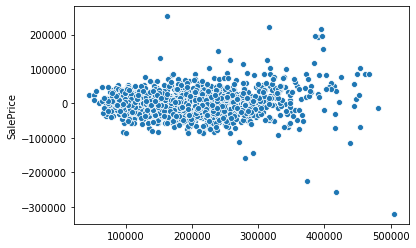

In [16]:
# This is a plot of the residuals of the ridge regression.
ax = sns.scatterplot(x=ridge_pred, y=resids_ridge, palette='husl', ci=95);

# # ax = sns.lmplot(x="Pred_Price", y="SalePrice", data=new_train, x_estimator=np.mean);
# new_train.columns